In [1]:
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import seaborn as sns

import os
if Path('.').absolute().parents[1].name == 'ml_drought':
    os.chdir(Path('.').absolute().parents[1])

from scripts.plotting_utils import (
    plot_geog_location, plot_xarray_on_map, 
)

from src.utils import drop_nans_and_flatten

%matplotlib inline

%load_ext autoreload
%autoreload 2


In [2]:
# set data and plot dir
if Path('.').absolute().owner() == 'tommylees':
    data_dir = Path('/Volumes/Lees_Extend/data/ecmwf_sowc/data')
    plot_dir = Path('/Users/tommylees/Downloads')
else:
    data_dir = Path('data')
    plot_dir = Path('.')  # ???

chirps_path = data_dir / "interim" / "chirps_preprocessed" / "chirps_kenya.nc"
analysis_path = data_dir / "analysis" 
all_indices_path = analysis_path / "indices" / "all_indices_kenya.nc"
vhi_path = data_dir / "interim" / "vhi_preprocessed" / "vhi_kenya.nc"
gleam_path = data_dir / "interim" / "gleam_preprocessed" / "gleam_kenya.nc"
era5_path = data_dir / "interim" / "era5POS_preprocessed" / "era5POS_kenya.nc"
esa_cci_lc1_path = data_dir / "interim" / "esa_cci_landcover_preprocessed" / "esa_cci_landcover_kenya_0.nc"
esa_cci_lc2_path = data_dir / "interim" / "esa_cci_landcover_preprocessed" / "esa_cci_landcover_kenya_1.nc"
esa_cci_lc_path = data_dir / "interim" / "esa_cci_landcover_preprocessed" / "esa_cci_landcover_kenya.nc"

[d.name for d in (data_dir/'interim' ).iterdir()]

['chirps_preprocessed',
 'era5_land_interim',
 'era5_land_preprocessed',
 'era5POS_preprocessed',
 'esa_cci_landcover_preprocessed',
 'gcloud',
 'gleam_preprocessed',
 'reanalysis-era5-land_preprocessed',
 's5_interim',
 's5_preprocessed',
 'TEMP',
 'vhi_interim',
 'vhi_preprocessed']

In [3]:
download_high_res = False

In [4]:
if download_high_res:
    ds2 = xr.open_dataset(esa_cci_lc1_path, chunks={'lat':100, 'lon':100})
    ds1 = xr.open_dataset(esa_cci_lc2_path)
    
ds = xr.open_dataset(esa_cci_lc_path)
legend = pd.read_csv(esa_cci_lc_path.parents[0] / 'legend.csv')
legend['new_code'] = np.arange(0, 380, 10)
ds_mask = xr.open_dataset(vhi_path).isel(time=0).isnull()['VHI'].rename('lc_class')

In [5]:
display(ds)
print()
display(legend.head())

<xarray.Dataset>
Dimensions:   (lat: 224, lon: 176, time: 277)
Coordinates:
  * time      (time) datetime64[ns] 1992-01-31 1992-02-29 ... 2015-01-31
  * lon       (lon) float32 33.524994 33.574997 33.625 ... 42.22499 42.274994
  * lat       (lat) float32 -5.175003 -5.125 -5.075001 ... 5.924999 5.9749985
Data variables:
    lc_class  (time, lat, lon) float64 ...

,Unnamed: 0,code,label,label_text,R,G,B,new_code
0,0,0,No data,no data,0,0,0,0
1,1,10,"Cropland, rainfed",cropland rainfed,255,255,100,10
2,2,11,Herbaceous cover,herbaceous cover,255,255,100,20
3,3,12,Tree or shrub cover,tree or shrub cover,255,255,0,30
4,4,20,"Cropland, irrigated or post-flooding",cropland irrigated or postflooding,170,240,240,40


# Plot the Landcover classes

In [6]:
if download_high_res:
    fig, ax = plt.subplots(1,2, figsize=(20,8))
    ds1.isel(time=0).lc_class.plot(ax=ax[0])
    ax[0].set_title('Low Resolution')
    ds2.isel(time=0).lc_class.plot(ax=ax[1])
    ax[1].set_title('High Resolution')

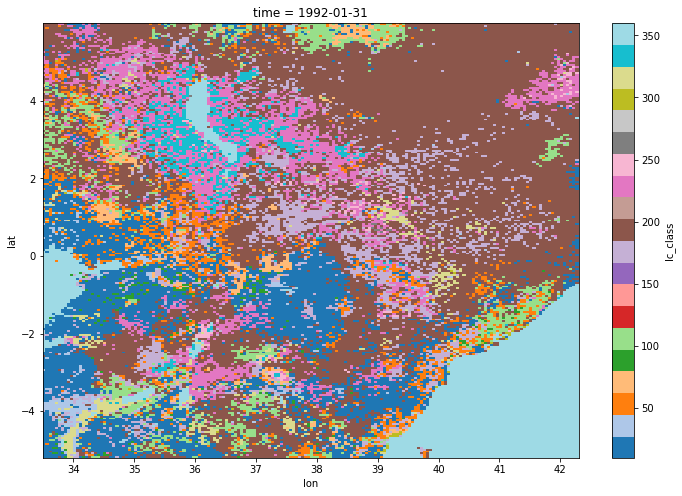

In [7]:
fig, ax = plt.subplots(figsize=(12,8))
ds.isel(time=0).lc_class.plot.pcolormesh(cmap='tab20', ax=ax)

## Plot the cateogircal data with categorical colormap
- [JVP Gist looking at Iris dataset](https://gist.github.com/jakevdp/8a992f606899ac24b711)
- [SO Question about matplotlib and categorical data](https://gis.stackexchange.com/questions/184996/plotting-classification-map-using-shapefile-in-matplotlib)

In [92]:
# get the lc data as a numpy array
da = ds.isel(time=0).lc_class  # ds_mask
lc = da.values
lc = np.ma.array(lc, mask=ds_mask.values)
lc = lc[::-1, :]

assert lc.shape == (224, 176)

actual_vals = np.unique(lc[~lc.mask])

In [98]:
# get the lookup of the values -> meanings
lookup = dict(zip(actual_vals, legend['label']))

In [99]:
# what landcover classes do we actually have?
from pprint import pprint
pprint([lookup[v] for v in actual_vals])

['No data',
 'Cropland, rainfed',
 'Herbaceous cover',
 'Tree or shrub cover',
 'Cropland, irrigated or post-flooding',
 'Mosaic cropland (>50%) / natural vegetation (tree, shrub, herbaceous cover) '
 '(<50%)',
 'Mosaic natural vegetation (tree, shrub, herbaceous cover) (>50%) / cropland '
 '(<50%) ',
 'Tree cover, broadleaved, evergreen, closed to open (>15%)',
 'Tree cover, broadleaved, deciduous, closed to open (>15%)',
 'Tree cover, broadleaved, deciduous, closed (>40%)',
 'Tree cover, broadleaved, deciduous, open (15-40%)',
 'Tree cover, needleleaved, evergreen, closed to open (>15%)',
 'Tree cover, needleleaved, evergreen, closed (>40%)',
 'Tree cover, needleleaved, evergreen, open (15-40%)',
 'Tree cover, needleleaved, deciduous, closed to open (>15%)',
 'Tree cover, needleleaved, deciduous, closed (>40%)',
 'Tree cover, needleleaved, deciduous, open (15-40%)',
 'Tree cover, mixed leaf type (broadleaved and needleleaved)',
 'Mosaic tree and shrub (>50%) / herbaceous cover (<50%)

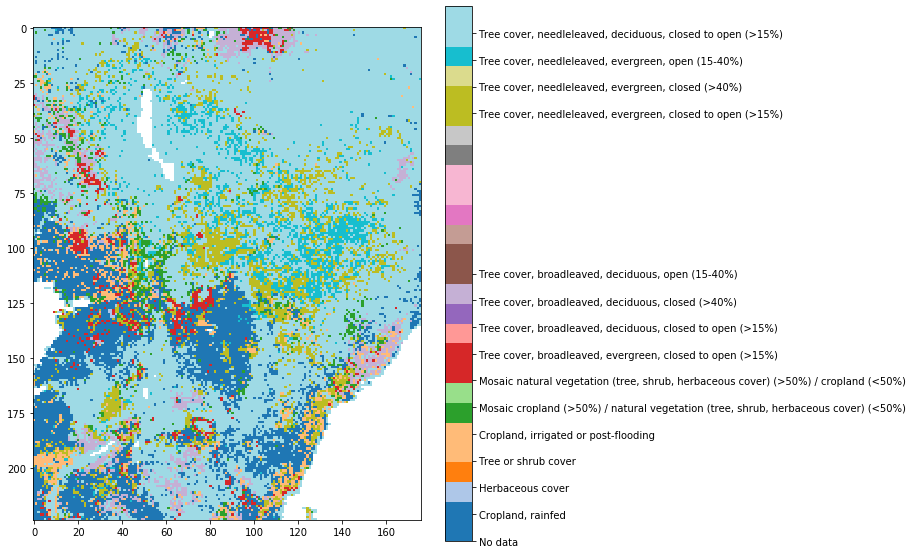

In [100]:
fig, ax = plt.subplots(figsize=(12, 8)) 
plt.imshow(lc, cmap=plt.cm.get_cmap('tab20', len(actual_vals)))

# formatter replacing integer values with target names
formatter = plt.FuncFormatter(lambda val, loc: lookup[val])

# We must be sure to specify the ticks matching our target names
plt.colorbar(ticks=actual_vals, format=formatter);

# center the labels?
plt.clim(10, 210)

plt.tight_layout()

# get the cropland areas

In [7]:
legend['crop'] = legend.label_text.apply(lambda x: 'cropland' in x)
crop_codes = (
    legend.new_code
    .where(legend.crop)
    .dropna().values
)
legend.head()

,Unnamed: 0,code,label,label_text,R,G,B,new_code,crop
0,0,0,No data,no data,0,0,0,0,False
1,1,10,"Cropland, rainfed",cropland rainfed,255,255,100,10,True
2,2,11,Herbaceous cover,herbaceous cover,255,255,100,20,False
3,3,12,Tree or shrub cover,tree or shrub cover,255,255,0,30,False
4,4,20,"Cropland, irrigated or post-flooding",cropland irrigated or postflooding,170,240,240,40,True


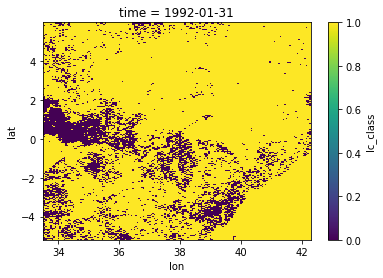

In [68]:
crop_masked = ds.where(np.isin(ds.lc_class, crop_codes))
crop_masked.isnull().isel(time=0).lc_class.plot()

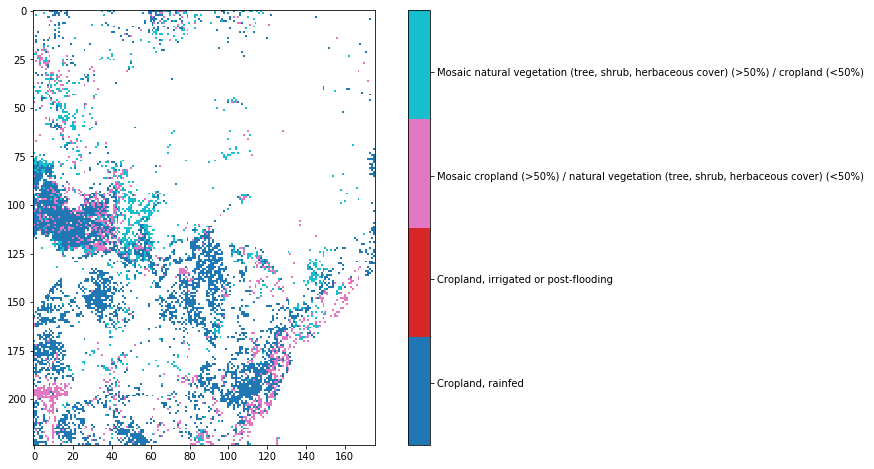

In [58]:
# (crop_masked
#  .isel(time=0).lc_class
#  .plot(cmap='tab10', cbar_kwargs=dict(format=formatter))
# )

fig, ax = plt.subplots(figsize=(12, 8)) 
im = crop_masked.isel(time=0).lc_class.values
im = im[::-1, :]
actual_vals = np.unique(im[~np.isnan(im)])
labels = legend.loc[legend.new_code.apply(lambda x: x in actual_vals)].label.values

plt.imshow(im, cmap=plt.cm.get_cmap('tab10', len(actual_vals)))

crop_lookup = dict(zip(actual_vals, labels))
# formatter = plt.FuncFormatter(lambda val, loc: crop_lookup[val])
min_ = min(actual_vals)
max_ = max(actual_vals)
positions = np.linspace(min_, max_, len(actual_vals))
# pos_lookup = dict(zip(np.arange(0, len(actual_vals)), positions))
val_lookup = dict(zip(positions, labels))

def formatter_func(x, pos):
    'The two args are the value and tick position'
    val = val_lookup[x]
    return val

formatter = plt.FuncFormatter(formatter_func)

# We must be sure to specify the ticks matching our target names
plt.colorbar(ticks=positions, format=formatter, spacing='proportional');

plt.clim(0, 70)

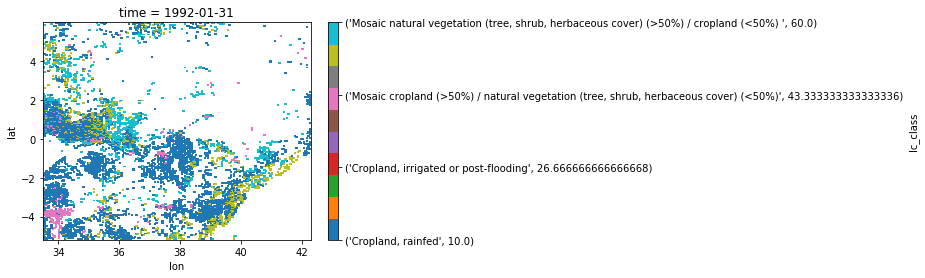

In [194]:
(crop_masked
 .isel(time=0).lc_class.isnull()
 .plot(cmap='tab10', cbar_kwargs=dict(format=formatter, ticks=positions))
)